# Model Calibration and Decision Curve

## Prepare the log data for analysis

### 1. Import the required libraries

In [1]:
import pandas as pd 
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt
from sklearn.utils.validation import column_or_1d
from sklearn.utils import check_consistent_length
from sklearn.preprocessing import label_binarize
import scipy
%matplotlib inline

### 2. Provide some general information about the log

In [2]:
### General input
use_case = 'sepsis'

customer = 'HDZ'
if customer == 'HDZ':
    date_logs =['20210219', '20210226', '20210305','20210319','20210409','20210416','20210507','20210521','20210528','20210604','20210611','20210618','20210625','20210709','20210723','20210806']

path = r'logs'

In [3]:
#Load the complete predictions
if use_case == 'aki':
    logs_data = pd.read_csv(f'{path}/belief_aki_HDZ_HDZ.csv', sep = ";")
elif use_case == 'sepsis':    
    logs_data = pd.read_csv(f'logs/belief_sep_HDZ_HDZ.csv', sep = ";")
elif use_case == 'del':
    logs_data = pd.read_csv(f'{path}/belief_del_HDZ_HDZ.csv', sep = ";")
    
#Cross-hospitals

#logs_data = pd.read_csv(f'logs/belief_sep_HDZ_MHS.csv', sep = ";")


logs_data = logs_data[['CASEID', 'ADJUSTED_BELIEF', 'LABEL', 'DATE']]
logs_data = logs_data.rename(columns={'ADJUSTED_BELIEF': 'BELIEF'})

### 3. Calibration Function

In [6]:
def calibration_plot(y_true, y_prob, *, normalize=False, n_bins=5, strategy="uniform"):
    y_true = column_or_1d(y_true)
    y_prob = column_or_1d(y_prob)
    check_consistent_length(y_true, y_prob)

    if normalize:  # Normalize predicted values into interval [0, 1]
        y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())
    elif y_prob.min() < 0 or y_prob.max() > 1:
        raise ValueError(
            "y_prob has values outside [0, 1] and normalize is set to False."
        )

    labels = np.unique(y_true)
    if len(labels) > 2:
        raise ValueError(
            "Only binary classification is supported. Provided labels %s." % labels
        )
    y_true = label_binarize(y_true, classes=labels)[:, 0]

    if strategy == "quantile":  # Determine bin edges by distribution of data
        quantiles = np.linspace(0, 1, n_bins + 1)
        bins = np.percentile(y_prob, quantiles * 100)
        bins[-1] = bins[-1] + 1e-8
    elif strategy == "uniform":
        bins = np.linspace(0.0, 1.0 + 1e-8, n_bins + 1)
    else:
        raise ValueError(
            "Invalid entry to 'strategy' input. Strategy "
            "must be either 'quantile' or 'uniform'."
        )

    binids = np.digitize(y_prob, bins) - 1
    bin_sums = np.bincount(binids, weights=y_prob, minlength=len(bins))
    bin_true = np.bincount(binids, weights=y_true, minlength=len(bins))
    bin_total = np.bincount(binids, minlength=len(bins))
    ci_down = []
    ci_up = []
    for i in range(0,len(bins)):
        bin_pred = y_prob[binids == i]
        bin_true1 = y_true[binids == i]
        r = sum(bin_true1)
        n = len(bin_true1)
        ci_1 = confidence(r,n)
        ci_down.append(ci_1[0])
        ci_up.append(ci_1[1])
        
    nonzero = bin_total != 0
    prob_true = bin_true[nonzero] / bin_total[nonzero]
    prob_pred = bin_sums[nonzero] / bin_total[nonzero]
    ci_down = np.asarray(ci_down)
    ci_down = ci_down[nonzero]
    ci_up = np.asarray(ci_up)
    ci_up = ci_up[nonzero]
    return prob_true, prob_pred, [ci_down, ci_up]


In [7]:
def confidence(r, n):
    z = scipy.stats.norm.ppf([.025, .975])
    if n == 0:
        ci = [0,0]
    else:
        ci = (
            (r + z**2/2) / (n + z**2)
            + z / (n + z**2) * np.sqrt(r*(n-r)/n + z**2/4)
            )
    return ci

## Logs/live data BEFORE Calibration

In [15]:
# Split the logs in two sets
date = '2021-04-20'
first_q = logs_data[logs_data.DATE < date]
second_q = logs_data[logs_data.DATE >= date]

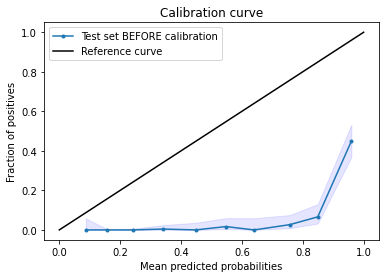

In [16]:
# Calibration curve of first set of logs before data calibration
prob_true_test_bef, prob_pred_test_bef,ci = calibration_plot(first_q.LABEL, first_q.BELIEF,n_bins = 10)

fig, ax = plt.subplots()
ax.plot(prob_pred_test_bef,prob_true_test_bef, marker='.', label = 'Test set BEFORE calibration')
ax.plot([0,1], [0,1], color = 'black', label = 'Reference curve')
ax.fill_between(prob_pred_test_bef, ci[0], ci[1], color='b', alpha=.1)
ax.set_xlabel("Mean predicted probabilities")
ax.set_ylabel("Fraction of positives")
ax.set_title('Calibration curve')
ax.legend()

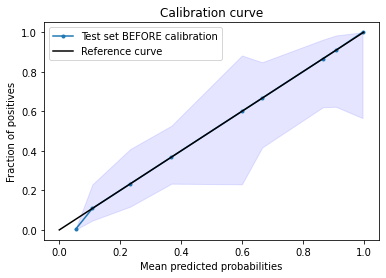

In [17]:
# Apply isotonic regression in the first logs set
iso_reg_new = IsotonicRegression(y_min = np.min(first_q.BELIEF), y_max = np.max(first_q.BELIEF), out_of_bounds='clip').fit(first_q.BELIEF, first_q.LABEL)
iso_pre_new = iso_reg_new.transform(first_q.BELIEF)

fig, ax = plt.subplots()
prob_true_calib, prob_pred_calib,ci = calibration_plot(first_q.LABEL, iso_pre_new,n_bins = 20)
ax.plot(prob_pred_calib,prob_true_calib, marker='.', label = 'Test set BEFORE calibration')
ax.plot([0,1], [0,1], color = 'black', label = 'Reference curve')
ax.fill_between(prob_pred_calib, ci[0], ci[1], color='b', alpha=.1)
ax.set_xlabel("Mean predicted probabilities")
ax.set_ylabel("Fraction of positives")
ax.set_title('Calibration curve')
ax.legend()

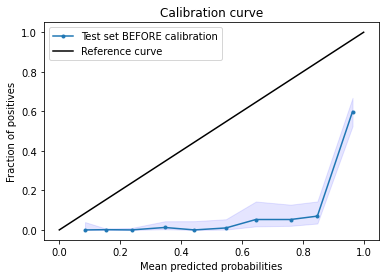

In [18]:
# Calibration curve of second set of logs before data calibration
fig, ax = plt.subplots()
prob_true_calib, prob_pred_calib,ci = calibration_plot(second_q.LABEL, second_q.BELIEF,n_bins = 10)
ax.plot(prob_pred_calib,prob_true_calib, marker='.', label = 'Test set BEFORE calibration')
ax.plot([0,1], [0,1], color = 'black', label = 'Reference curve')
ax.fill_between(prob_pred_calib, ci[0], ci[1], color='b', alpha=.1)
ax.set_xlabel("Mean predicted probabilities")
ax.set_ylabel("Fraction of positives")
ax.set_title('Calibration curve')
ax.legend()

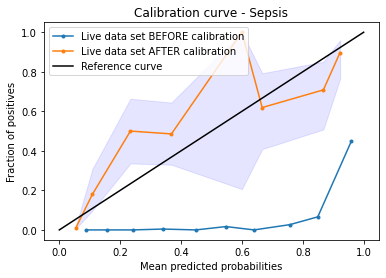

In [20]:
# Apply the isotonic regression in the first set.
iso_pre_new = iso_reg_new.transform(second_q.BELIEF)

# re-compute the calibration curve for the second log set
prob_true_test_after, prob_pred_test_after,ci = calibration_plot(second_q.LABEL, iso_pre_new,n_bins = 10)
fig, ax = plt.subplots()
ax.plot(prob_pred_test_bef,prob_true_test_bef, marker='.', label = 'Live data set BEFORE calibration')
ax.plot(prob_pred_test_after,prob_true_test_after, marker='.', label = 'Live data set AFTER calibration')
ax.plot([0,1], [0,1], color = 'black', label = 'Reference curve')
ax.fill_between(prob_pred_test_after , ci[0], ci[1], color='b', alpha=.1)
ax.set_xlabel("Mean predicted probabilities")
ax.set_ylabel("Fraction of positives")
ax.set_title('Calibration curve - Sepsis')
ax.legend()

## Decision Curve

In [13]:
#Calculate the net benefit of our model and the strategy of alerts all
step = 0.15
prob = np.arange(0, 1, step).tolist()
net_benefit = []
alert_all = []
iso_pre = iso_pre_new
for p in prob:
    pred_labels = np.where(iso_pre >= p,1,0)
    tn, fp, fn, tp = confusion_matrix(second_q.LABEL, pred_labels).ravel()
    n = len(iso_pre)
    net_benefit.append((tp/n) - (fp/n)*(p/(1-p)))
    alert_all.append(((tp+fn)/n) - ((fp+tn)/n)*(p/(1-p)))

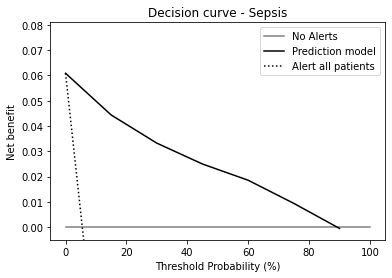

In [14]:
# plot the net benefits to get the decision curve
plt.plot([0,100], [0,0], color = 'gray', label = 'No Alerts')
plt.plot(np.multiply(prob,100)  , net_benefit, color = 'black', label = 'Prediction model')
plt.plot(np.multiply(prob,100)[:3], alert_all[:3], color = 'black',linestyle='dotted', label = 'Alert all patients')

plt.xlabel("Threshold Probability (%)")
plt.ylabel("Net benefit")
plt.title('Decision curve - Sepsis')
plt.ylim(bottom=-0.005) 
plt.legend()